### 1.1 Model Parameters

In [3]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split

In [5]:
DATA_DIR = 'airbus-ship-detection'
TRAIN_DIR = DATA_DIR + '/train_v2/'
TEST_DIR = DATA_DIR + '/test_v2/'

In [6]:
train = os.listdir(TRAIN_DIR)
test = os.listdir(TEST_DIR)

print(f"Train: {len(train)}. => {train[:5]}")
print(f"Test:  {len(test)}. => {test[:5]}")

Train: 192556. => ['00003e153.jpg', '0001124c7.jpg', '000155de5.jpg', '000194a2d.jpg', '0001b1832.jpg']
Test:  15606. => ['00002bd58.jpg', '00015efb6.jpg', '00023d5fc.jpg', '000367c13.jpg', '0008ca6e9.jpg']


In [7]:
masks = pd.read_csv(os.path.join(DATA_DIR, 'train_ship_segmentations_v2.csv'))
ships = pd.notna(masks.EncodedPixels)
print(ships.sum(), 'masks in', masks[ships].ImageId.nunique(), 'images')
print((~ships).sum(), 'empty images in', masks.ImageId.nunique(), 'total images')
masks.head()

81723 masks in 42556 images
150000 empty images in 192556 total images


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


### 1.2 Data Preparation Tools

In [9]:
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
masks.drop(['ships'], axis=1, inplace=True)
print(unique_img_ids.loc[unique_img_ids.ships>=3].head())

           ImageId  ships  has_ship
3    000194a2d.jpg      5       1.0
5    00021ddc3.jpg      9       1.0
45   00113a75c.jpg      7       1.0
81   001aee007.jpg      4       1.0
117  002943412.jpg      3       1.0


Max of ships :  15
Avg of ships :  0.4244115997424126


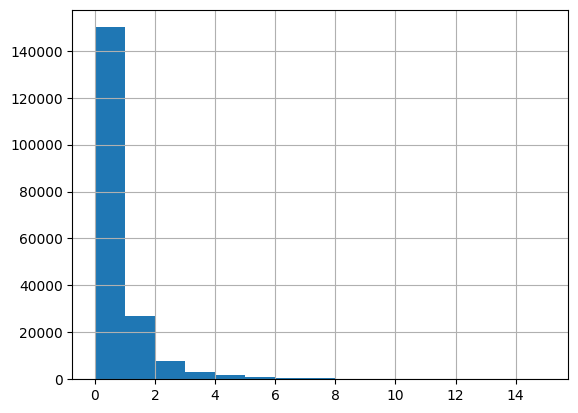

In [10]:
unique_img_ids['ships'].hist(bins=unique_img_ids['ships'].max())
print('Max of ships : ',unique_img_ids['ships'].max())
print('Avg of ships : ',unique_img_ids['ships'].mean())

## 2. Make dataset

### 2.1 Undersample Empty Images

19778 masks


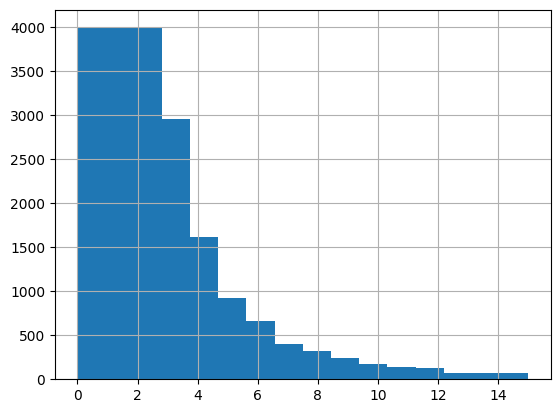

In [11]:
SAMPLES_PER_GROUP = 4000
balanced_train_df = unique_img_ids.groupby('ships').apply(lambda x: x.sample(SAMPLES_PER_GROUP) if len(x) > SAMPLES_PER_GROUP else x)
balanced_train_df['ships'].hist(bins=balanced_train_df['ships'].max()+1)
print(balanced_train_df.shape[0], 'masks')

### 2-2. Split train & test set

In [12]:
train_ids, valid_ids = train_test_split(balanced_train_df,
                 test_size = 0.15,
                 stratify = balanced_train_df['ships'])
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
train_df.to_csv('train_df.csv')
valid_df.to_csv('valid_df.csv')
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

46979 training masks
8292 validation masks
